### Overture

This notebook reproduces the results from [Weng et al](https://doi.org/10.1016/j.joule.2021.09.015). _Predicting the impact of formation protocols on battery lifetime immediately after manufacturing_.

<**Synopsis**: Cell resistance immediately following formation was statistically shown to be an indicator of future performance.

It is highly recommended for the reader to familiarize oneself with the paper before proceeding. This is intended as a pure, barebone reproduction; explanations are sparse and concise.

It is intentionally high-level to keep the codespace as clean as possible, with two supplementary modules `figures.py` and `utils.py` doing the grunt work.

In [13]:
%matplotlib inline

import voltaiq_studio as vs

import figures
import utils

### Dataset

Load in all data from UMich.

Note that it only takes two lines of code to load the entire dataset into a homogenous, pythonic structure (`list[vs.test_record.test_record.TestRecord]`). Subsequent code blocks are for the actual analysis.

In [14]:
trs = vs.get_test_records()
um_dataset = [tr for tr in trs if('UM ' in tr.name)]

The dataset contains two categories, each containing two subcategories (I made it in draw.io, modeling figure S1a in the original paper):

![Experiment protocol](static/protocol.png)

We're going to parse the data to `dict` containing the following key-value pairs.

-- `name`: `str`

-- `cycling`: `pd.DataFrame`

-- `formation`: `pd.DataFrame`

-- `high_temperature`: `bool` (45 or ambient)

-- `fast_formation`: `bool` (fast or normal)}

-- (some others are added later on)

In [15]:
keys = ['cycling', 'high_temperature', 'fast_formation']
no_formation_cycles = 10

# The data keys pertinent to this analysis
trace_keys = utils.get_json("trace_keys")

# Preallocating
categorized_experiments = dict()
formations = dict()

for experiment in um_dataset:
    serial_no = utils.generate_exp_id(name=experiment)
    df = utils.load_data_by_experiment(
        experiment=experiment,
        trace_keys=trace_keys['trace_keys']
    )
    
    if experiment.total_cycles < no_formation_cycles:  # If in formation
        df_zero_shifted = utils.zero_shift_formation(df)
        formations[serial_no] = df_zero_shifted
        continue

    temperature = 1 if 'HT' in experiment.name else 0 
    formation = 1 if 'Micro' in experiment.name else 0
    
    data = dict(zip(keys, [df, temperature, formation]))
    categorized_experiments[serial_no] = data

categorized_experiments = utils.match_cycling_with_formation(
    categorized_experiments,
    formations
)

### Figure 1: Fast formation superior to baseline formation

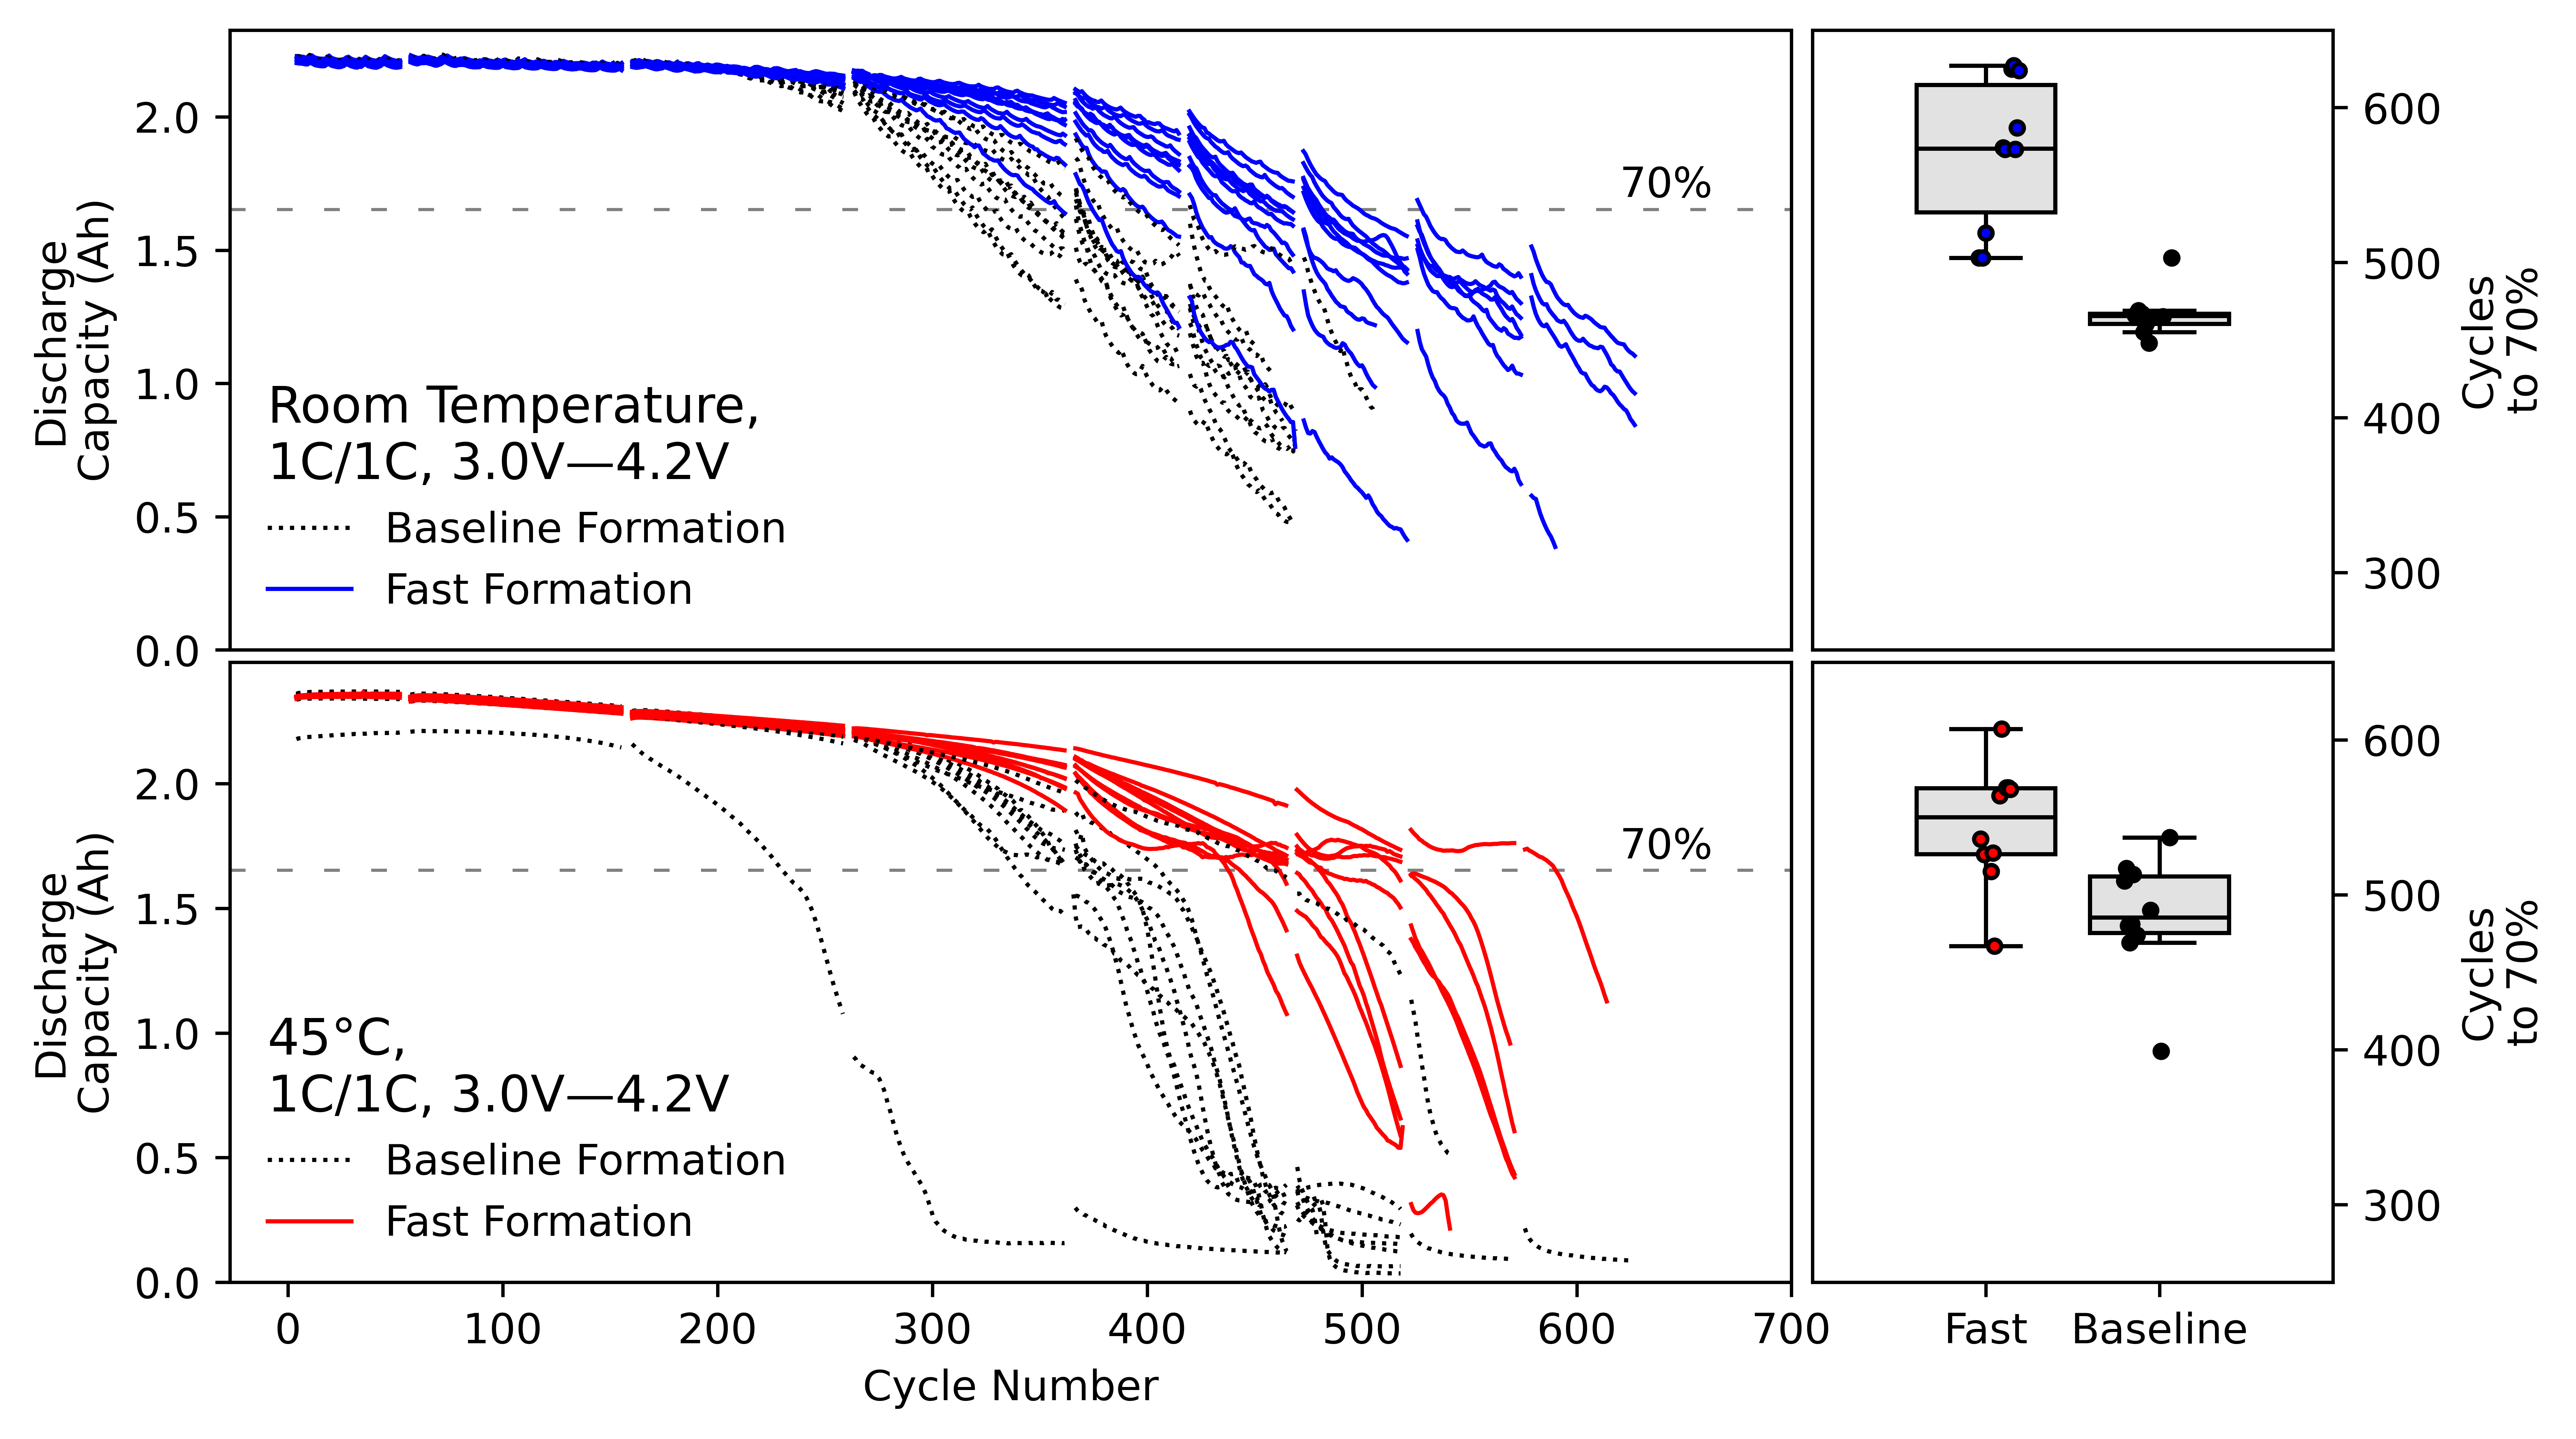

In [16]:
fig1 = figures.Figure1()
NOMINAL_CAPACITY = 0.236  # Ah

categorized_cycles_to_70 = [[[], []], [[], []]]
for i, (cell_id, params) in enumerate(categorized_experiments.items()):

    # Grouping
    by_cycle = params['cycling'].groupby(by='h_cycle').max()
    discharge_capacity = by_cycle.h_discharge_capacity.to_numpy()
    cycles_to_70 = sum(discharge_capacity > 0.7*NOMINAL_CAPACITY)

    # Figure logic
    c = 'red' if params['high_temperature'] else 'blue'
    c = c if params['fast_formation'] else 'k'
    x_pos = 0 if params['fast_formation'] else 1
    row = 1 if params['high_temperature'] else 0
    linestyle = 'solid' if params['fast_formation'] else 'dotted'

    categorized_experiments[cell_id]['cycles_to_70'] = cycles_to_70
    categorized_cycles_to_70[row][x_pos].append(cycles_to_70)

    fig1.scatterplot(
        cycles_to_70=cycles_to_70,
        row=row,
        x_pos=x_pos,
        shifter=i,
        c=c
    )

    # Line plot on left
    hppc_indices = utils.filter_HPPC(by_cycle=by_cycle, threshold=0.1)
    cycles_w_hppc = []
    for i in range(2, len(hppc_indices)):
        # Skipping the embedded reference performance tests
        if abs(hppc_indices[i-1] - hppc_indices[i]) < 10:
            continue

        fig1.lineplot(
            discharge_capacity=discharge_capacity,
            hppc_indices=hppc_indices,
            i=i,
            c=c,
            linestyle=linestyle,
            row=row
        )

legend_colors = ['b', 'r']
legend_title = ['Room Temperature,\n1C/1C, 3.0V—4.2V',
                '45°C,\n1C/1C, 3.0V—4.2V']

for row in range(2):
    fig1.legend(
        legend_title=legend_title[row],
        c=legend_colors[row],
        row=row
    )

    for col in range(2):
        x_pos = col
        fig1.boxplot(
            row=row,
            x_pos=x_pos,
            categorized_cycles_to_70=categorized_cycles_to_70
        )

    fig1.capacity_fade_line(row=row)
    fig1.properties(row=row)


fig1.showme()

Original figure:

![Figure 1](static/figure_1.png)

---

Let's see whether there's a statistically significant difference in the cycling performance between the two protocols.

The original paper reports $p<0.001$ for both temperatures. However, exact values are not specified.

In [17]:
for temperature in range(2):
    p_val = utils.get_p_val(
        var_1=categorized_cycles_to_70[temperature][0],
        var_2=categorized_cycles_to_70[temperature][1]
    )
    print("{:.1E}".format(p_val))

3.7E-06
3.4E-03


Both p-values are in agreement with the original findings.

---

Before going any further we should look at the two formation protocols. The following two figures are modified versions of Fig S1 b) & c), and S8 a).

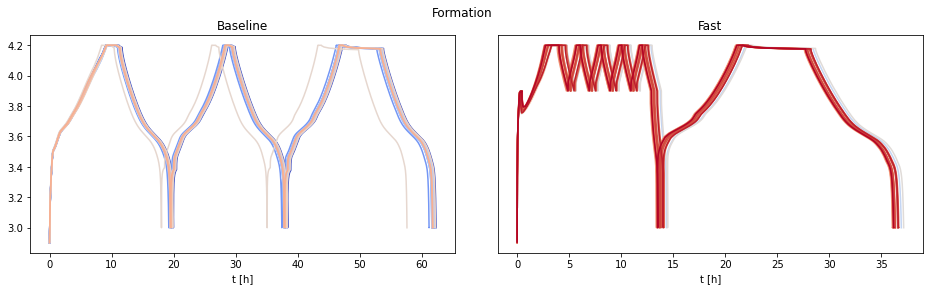

In [18]:
titles = ['Baseline', 'Fast']
no_curves = len(categorized_experiments)
no_cols = 2
formation_fig = figures.FormationFigure(no_cols=no_cols, no_curves=no_curves)

for i, params in enumerate(categorized_experiments.values()):
    col = 1 if params['fast_formation'] else 0
    df = params['formation']

    formation_fig.lineplot(col=col, df=df, i=i)

formation_fig.properties(no_cols=no_cols, titles=titles)

formation_fig.showme()

and also the first few cycles after formation

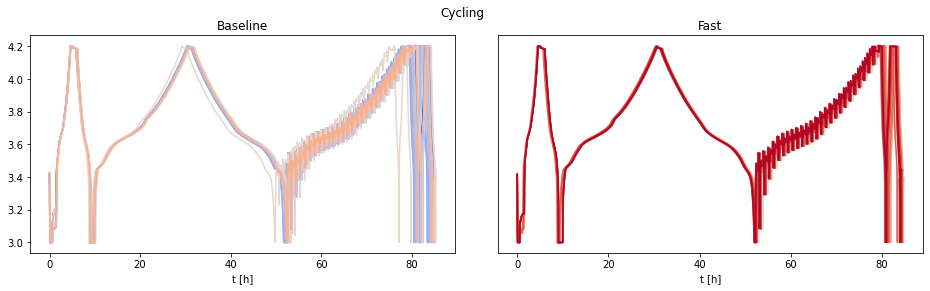

In [19]:
adolescence_fig = figures.AdolescenceFigure(no_cols=no_cols, no_curves=no_curves)
for i, params in enumerate(categorized_experiments.values()):
    col = 1 if params['fast_formation'] else 0
    df = params['cycling']
    df = df[df.h_cycle < 5]

    adolescence_fig.lineplot(col=col, df=df, i=i)

adolescence_fig.properties(no_cols=no_cols, titles=titles)

adolescence_fig.showme()

We want to extract $V$ and $I$ from the 'jagged' charge step to calculate the resistance. It is there that the high current pulse was applied.

### Figure 2

This figure is essentially two separate subfigures: The upper row is all conventional electrochemical properties, whereas the lower one contains resistance plots.

Do note that I change the color scheme a little bit.

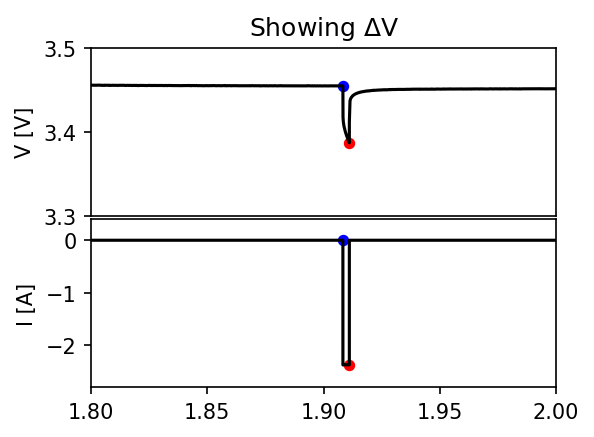

In [20]:
Q_ds = [[], []]  # Discharge capacity after formation
Q_LLIs = [[], []]  # Loss of Lithium inventory
CEs = [[], []]  # Coulombic Efficiency
Rs = []  # Cell resistance
R_5s = [[], []]
R_90s = [[], []]

for i, (cell_id, params) in enumerate(categorized_experiments.items()):
    formation_by_cycle = params['formation'].groupby(by='h_cycle').max()

    charge_capacity, discharge_capacity = utils.get_capacities(
        formation=formation_by_cycle
    )
    
    # For fig logic
    x_pos = 0 if params['fast_formation'] else 1
        
    # Q_d
    categorized_experiments[cell_id]['Q_d'] = discharge_capacity
    Q_ds[x_pos].append(discharge_capacity)

    # Q_LLI
    Q_LLI = charge_capacity - discharge_capacity
    categorized_experiments[cell_id]['Q_LLI'] = Q_LLI
    Q_LLIs[x_pos].append(Q_LLI)
    
    # CE
    CE = discharge_capacity / charge_capacity
    categorized_experiments[cell_id]['CE'] = CE
    CEs[x_pos].append(CE)
    
    # Rs
    R = utils.get_resistance(cycling=params['cycling'], to_plot=i)
    Rs.append(R)
    
    if params['high_temperature']:
        R_5 = utils.get_R5SoC(Rs=R[0:2])
        R_5s[x_pos].append(R_5)

    categorized_experiments[cell_id]['R_5'] = R_5
    categorized_experiments[cell_id]['R_90'] = R[-3]
    R_90s[x_pos].append(R[-3])


metrics = [Q_ds, Q_LLIs, CEs]


This zoomed-in figure demonstrates how we calculate $\Delta \mathrm{V}$ for each current pulse, i.e. $\color{blue}{\mathrm{V}}$ subtracted from $\color{red}{\mathrm{V}}$.

Figure properties:

In [21]:
ylabels = ['$\mathrm{Q_d}$ (Ah)',
           '$\mathrm{Q_{LLI} = Q_c - Q_c}$ (Ah)',
           '$\mathrm{CE_f (\%)}$']
x_positions = [0, 1]
colors = ['g', 'k']
xlims = [[0, 100],[3, 10]]

Figure implementation

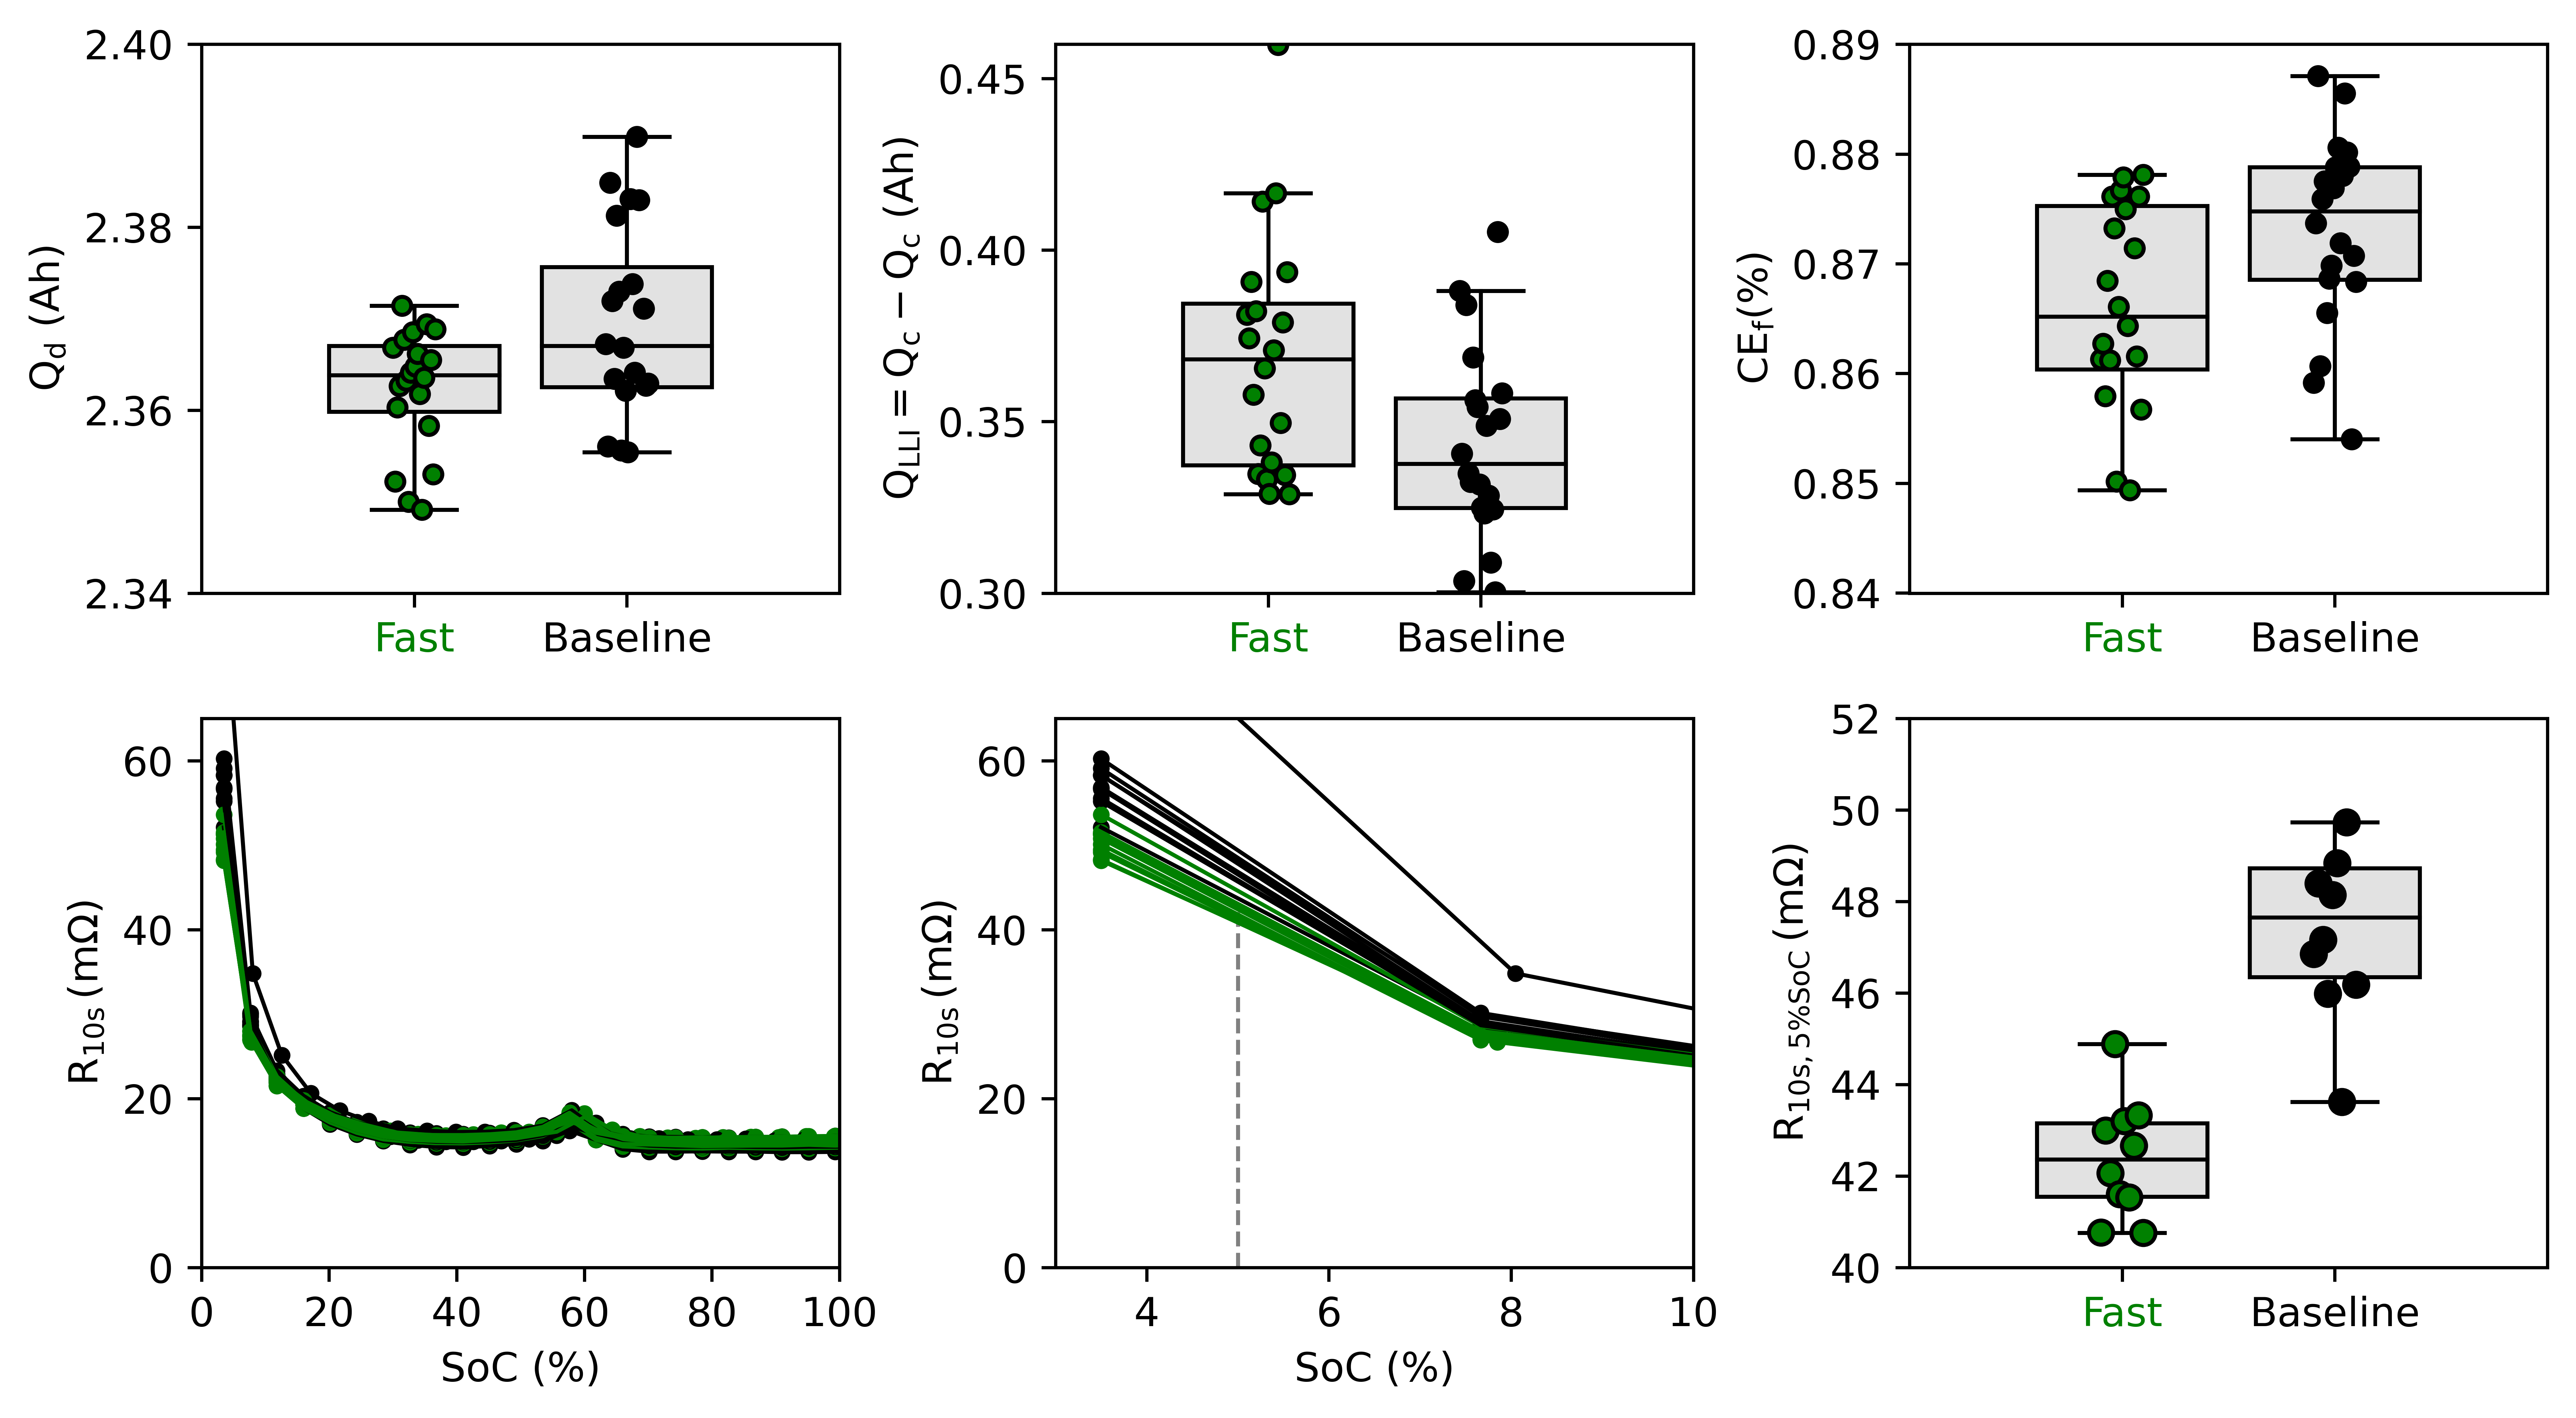

In [22]:
fig2 = figures.Figure2()

for x_pos in x_positions:        
    fig2.scatterplot_lower(
        R_5SoC=R_5s[x_pos],
        x_pos=x_pos,
        c=colors[x_pos]
    )
    fig2.boxplot_lower(
        R_5SoC=R_5s[x_pos],
        x_pos=x_pos
    ) 
    for col, metric in enumerate(metrics):
        fig2.scatterplot(
            metric=metric[x_pos],
            col=col,
            x_pos=x_pos,
            c=colors[x_pos]
        )
        fig2.boxplot(
            metric=metric[x_pos],
            x_pos=x_pos,
            col=col,
            ylabel=ylabels[col]
        )

for i, params in enumerate(categorized_experiments.values()):
    if not params['high_temperature']: 
        continue  # They only included high T cells in this fig
        
    c = 'g' if params['fast_formation'] else 'k'
    for col in range(2):
        fig2.lineplot(
            R=Rs[i],
            xlim=xlims[col],
            c=c,
            col=col
        )
        
fig2.showme()

Original figure:
    
![figure 2](static/figure_2.png)

### Figure 3: Modeling Diagnostic Signals

Figure properties:

In [23]:
xlabels = ['$\mathrm{Q_{LLI}}$ (Ah)',
           '$\mathrm{CE_f}$ ( )',
           '$\mathrm{R_{10s,\,5\%SOC}\,(m\Omega)}$',
           '$\mathrm{R_{10s,\,90\%SOC}\,(m\Omega)}$']
xlims = [[0.20, 0.60],
         [0.8, 1.0],
         [20, 80],
         [10, 30]]  # Manual
ylabel = 'Cycles\nto 70%'

variables = ['Q_LLI', 'CE', 'R_5', 'R_90']

Figure implementation.

Note that I change the axes limits significantly.

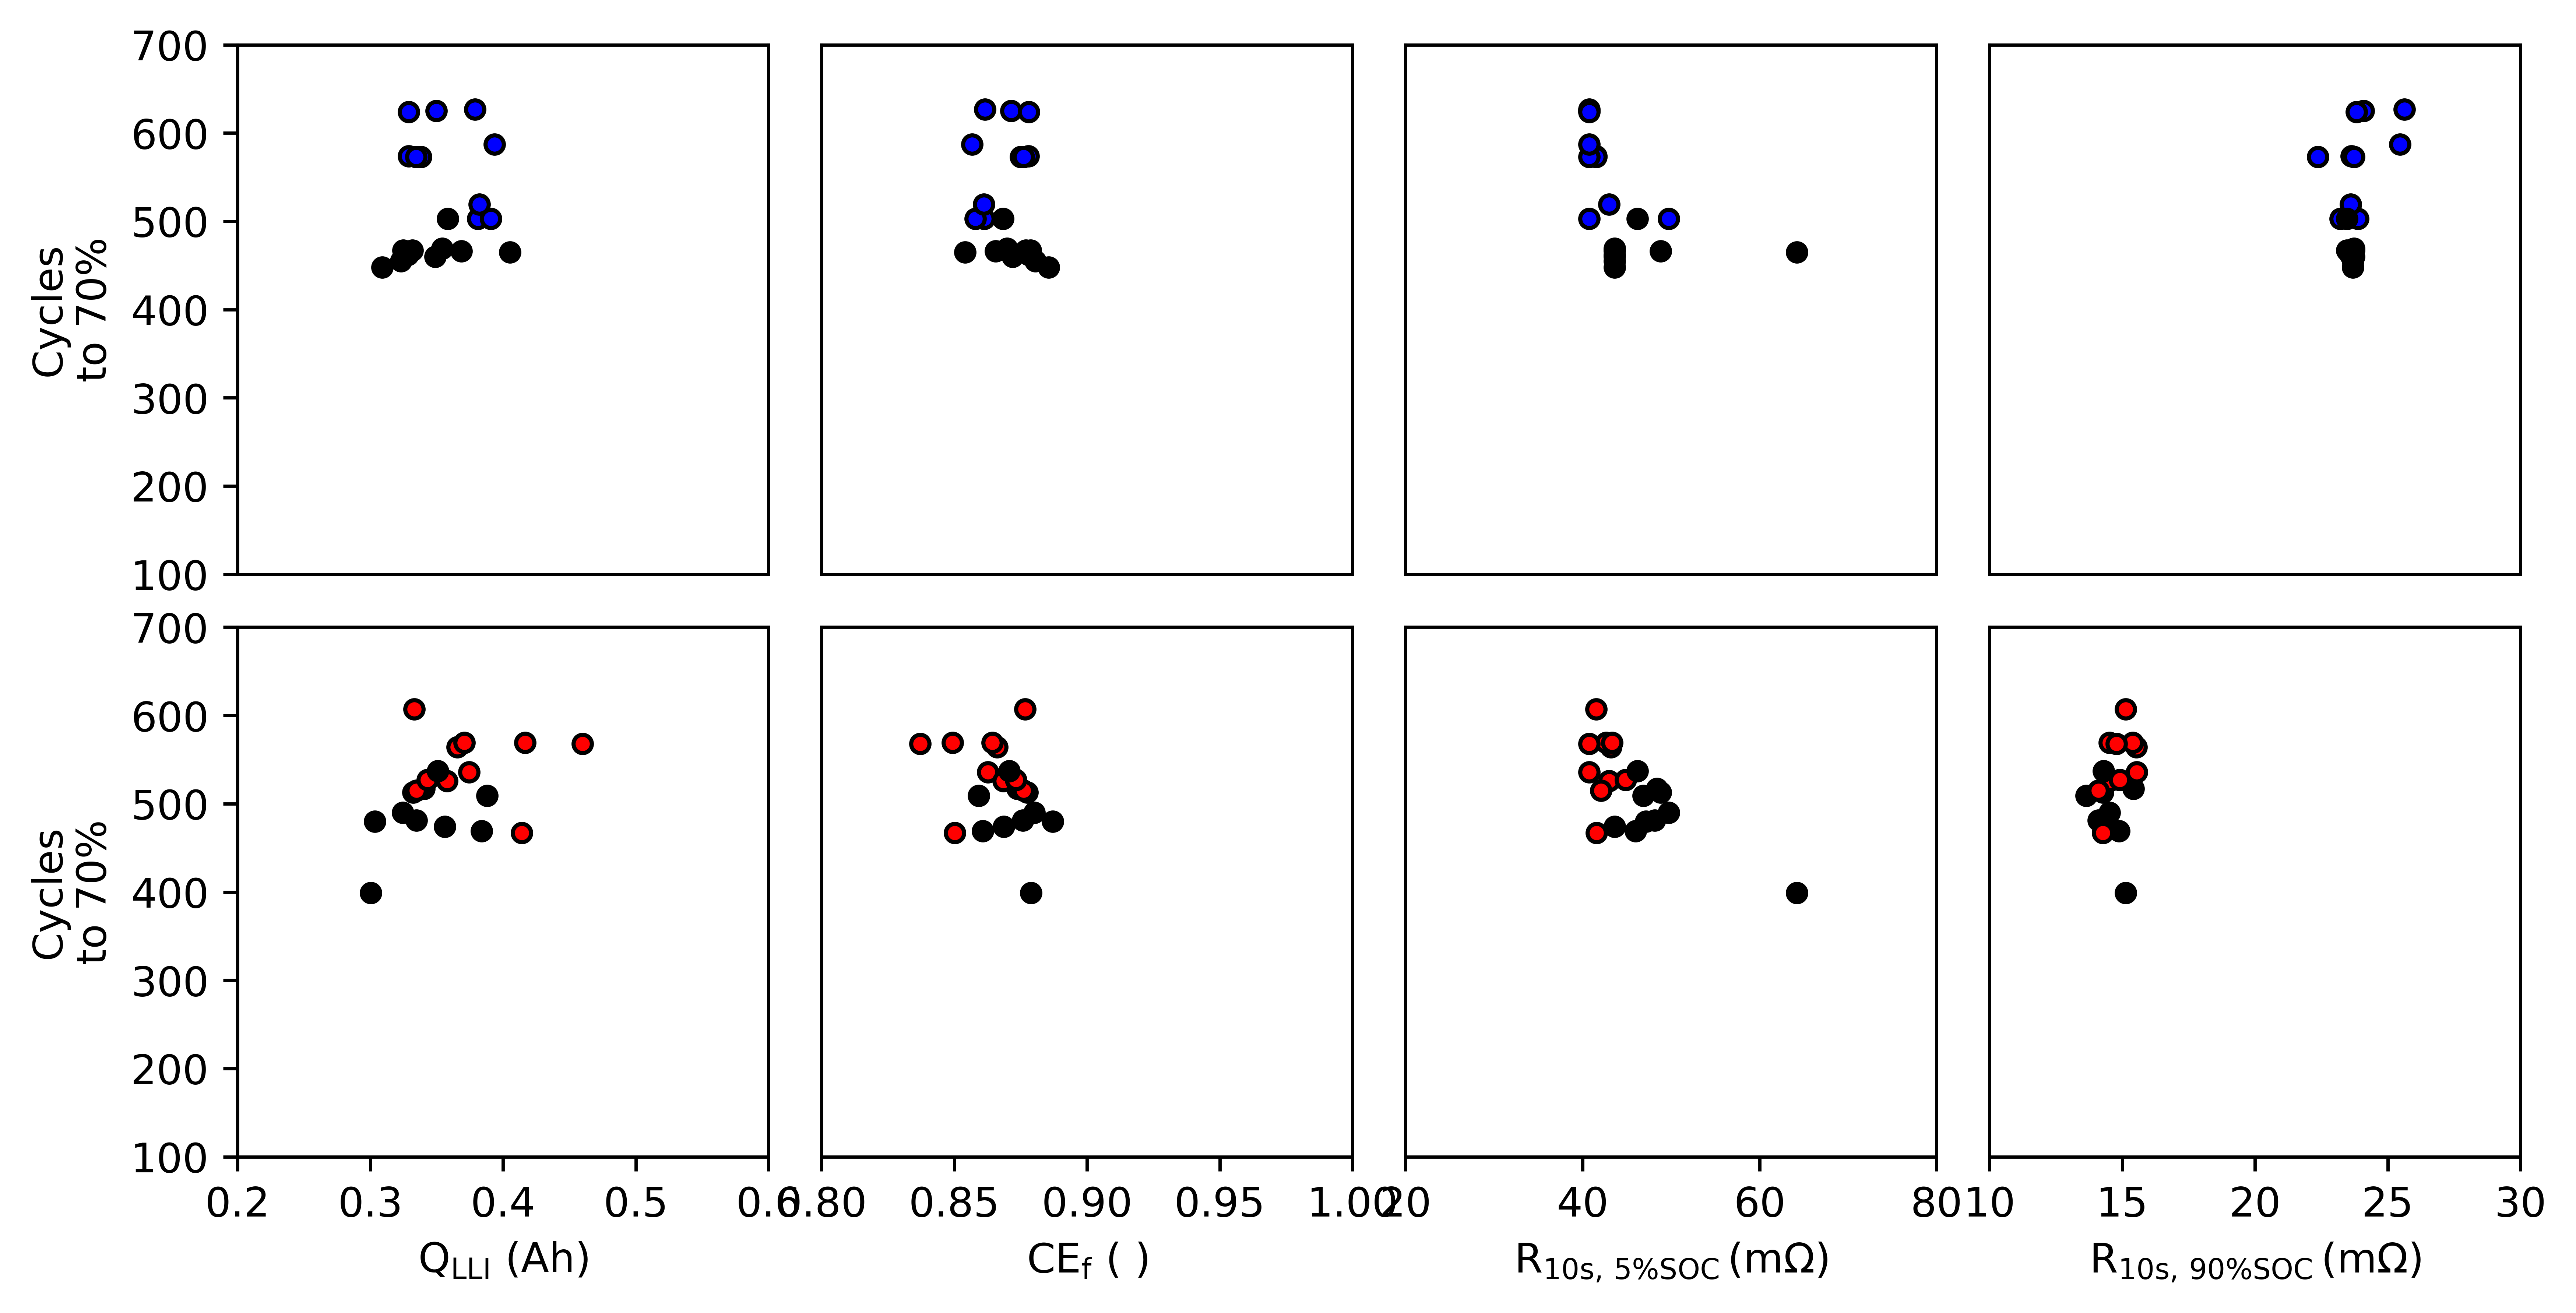

In [25]:
fig3 = figures.Figure3()
        
for i, params in enumerate(categorized_experiments.values()):
    c = 'red' if params['high_temperature'] else 'blue'
    c = c if params['fast_formation'] else 'k'
    row = 1 if params['high_temperature'] else 0

    for col, variable in enumerate(variables):
        fig3.scatterplot(
            variable=params[variable],
            cycles_to_70=params['cycles_to_70'],
            row=row,
            col=col,
            c=c
        )
        fig3.properties(
            xlabel=xlabels[col],
            xlim=xlims[col],
            col=col,
            ylabel=ylabel
        )
    
fig3.showme()

Original figure:

![figure 3](static/figure_3.png)

All in all I'd say that the reproduction matches the original ones quite well. Any differences are minute and don't affect the statistical interpretation.I guess that can be construed as the original paper being a solid piece of work.

The most challenging part was calculating the resistance, as it required clipping the HPPC cycle in a very specific manner.